In [12]:
# Code Author: Chirag Mirani
# Date: January 24, 2022

# In this project, we are demonstrating how to load the OpenAI gym environment and take random actions.
#!pip install gym[atari,accept-rom-license]
from google.colab import files
uploaded = files.upload()


# we are importing gym library to render space invadors
import gym
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

Saving HC ROMS.zip to HC ROMS.zip
Saving ROMS.zip to ROMS.zip


In [13]:
!python -m atari_py.import_roms .

#https://github.com/openai/atari-py/issues/83


copying adventure.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Adventure (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Air Raid (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Alien.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying crazy_climber.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Crazy Climber.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/crazy_climber.bin
copying elevator_action.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Elevator Action (Prototype).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/elevator_action.bin
copying gravitar.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Gravitar.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_

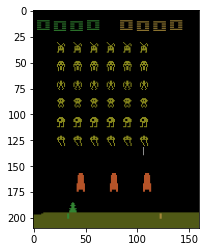

In [14]:
# loading space invaders pixel based environment
# For pixel based environment one should use neural network
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()
#env = gym.make('SpaceInvaders-v0')
env = gym.make("SpaceInvaders-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')
  
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break
    
ipythondisplay.clear_output(wait=True)
env.close()


In [15]:
display.stop()

In [16]:
episodes = 2  # we are going to play 10 Space Invaders game episodes

In [17]:
# start from Space Invaders game episode one and take random actions
for episode in range(1, episodes):  
    
    # first reset the environment and game state
    state = env.reset()
    done = False
    
    #initialize score to 0..
    score = 0
    
    #keep playing the game while the game is not done
    while not done:
        env.render()   #render the environment
        # take an action and get the next state, reward, whether we are done and information about the environment
        state, reward, done, info = env.step(env.action_space.sample())  # there are six actions we can take in space invaders. Start with random action
        score +=reward  # store rewards
    print ('Episode: {}\nScore: {}'.format(episode, score))  # prints out score for each game episodes

# don't forget to close the environment
env.close()

Episode: 1
Score: 85.0


In [18]:
# for reference print out number of actions
print(env.action_space)


Discrete(6)


In [19]:
# next we are going to use a neural network to figure out optimal actions.
# import numpy
import numpy as np

# sequence of layers are needed
from tensorflow.keras.models import Sequential

# these are different types of layers you can have a neural network
# Dense is a fully connected neural network
# Flatten layer just flattens the previous neutral network into a one dimensional array
# Convolution2d layer is needed to understand the images.  In this case, Space-Invador2.0
from tensorflow.keras.layers import Dense, Flatten, Conv2D

# Adam optimizer.  This optimizer will help us train the neural network such that it associates images with optimal actions
from tensorflow.keras.optimizers import Adam

In [20]:
# In this function, we are building our neural network. 
# these are pixels for our SpaceInvadersscreen (height, width, channels)
# Colored images typically have three channels, for the pixel value at the (row, column) coordinate for the red, green, and blue components.

# actions
# Main input: input shape = our space invaders image
# Main output: associate it with the six actions. 
def build_model(height, width, channels, actions):
    # sequence of layers
    model= Sequential()
    # take in the image and condense the image..
    # relu activation means the model is able to learn non-linear input/output relationships.  This allows for
    # more complicated relationships. Training the neural network will work like this.  Take in an input and associate it 
    # with the best action.
    model.add(Conv2D(32,(8,8), strides=(4,4), activation ='relu', input_shape=(3, height, width, channels)))
    #output unit 64, (4,4) and strides = (2,2) are filters that will help the model understand the image better
    model.add(Conv2D(64,(4,4), strides=(2,2),activation='relu'))
    
    #flatten image convolutions into one dimensional array
    model.add(Flatten())
    
    # send the flattened image to 512 neurons
    model.add(Dense(512,activation='relu'))
    
    # condense the associated image to 256 neurons
    model.add(Dense(256, activation='relu'))
    
    # output an action..
    model.add(Dense(actions, activation='linear'))
    return model

In [28]:
del model
#!pip install keras-rl2

In [29]:
#now we are ready to learn from any screen we pass into the model. 
# above we have our neural network setup. 
# Take in the observation space
height, width, channels = env.observation_space.shape
#specify number of actions.  This will be the output of our neural network
actions = env.action_space.n

model = build_model(height, width, channels, actions)
env.observation_space.shape

#importing keras-rl2 reinforcement learning functions
# This is the reinforcement learning algorithm that was used in OpenAI's atari bot..
from rl.agents import DQNAgent
#Sequential Memory is the dataset memory is trained off
from rl.memory import SequentialMemory

#policy is the behaviour 
# Greedy policy is the behaviour that results in the highest reward
# mental note: Think of policy as an optimization function
# we will pass Greedy policy into LinearAnnealedPolicy
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

#create an agent
def build_agent(model, actions):
    #first initialize policy
    policy=LinearAnnealedPolicy(EpsGreedyQPolicy(), attr="eps", value_max=1, value_min=0.1,  value_test=0.2, nb_steps=10000)
    
    #memory is sequential memory
    memory = SequentialMemory(limit=2000, window_length =3)
    
    #finally we create teh agent. 
    #research papers showed enabling dueling netowrk resulted in a better preformance
    dqn=DQNAgent(model=model, memory=memory, policy=policy, enable_dueling_network=True, dueling_type='avg', nb_actions=actions,
                nb_steps_warmup=1000)
    #return DQN netork
    return dqn





In [30]:
#!pip install keras-rl2   

In [31]:
#build an agent..
dqn =build_agent(model, actions)

In [32]:
#compile the agent and set the learning rate...
# smaller learning rate requires longertime to compile. 
# play around with the learning rate to improve results
dqn.compile(Adam(learning_rate=0.0001))

In [ ]:
#now lets train the agent on the environment
dqn.fit(env,nb_steps=40000,visualize=False, verbose=1)

Training for 40000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 6391s 639ms/step - reward: 0.2185
15 episodes - episode_reward: 141.333 [40.000, 535.000] - loss: 1.158 - mean_q: 3.208 - mean_eps: 0.505 - ale.lives: 2.061

Interval 2 (10000 steps performed)
 3596/10000 [=========>....................] - ETA: 1:15:16 - reward: 0.2280

In [40]:
#env.close()
env.reset()
scores=dqn.test(env, nb_episodes=10, visualize=True)
print(np.mean(scores.history['episode_reward']))
#the link below helps you in installing atari on google colab
#https://github.com/openai/atari-py/issues/83


Testing for 10 episodes ...
Episode 1: reward: 90.000, steps: 413
Episode 2: reward: 90.000, steps: 492
Episode 3: reward: 200.000, steps: 741
Episode 4: reward: 110.000, steps: 660
Episode 5: reward: 365.000, steps: 1067
Episode 6: reward: 85.000, steps: 663
Episode 7: reward: 20.000, steps: 429
Episode 8: reward: 190.000, steps: 1077
Episode 9: reward: 175.000, steps: 895
Episode 10: reward: 175.000, steps: 957
150.0


In [ ]:
env.close()


In [ ]:
dqn.save_weights('models/ChiragsDQNSpaceInvadersRLModel.h5f')

In [ ]:
dqn.load_weights('models/ChiragsDQNSpaceInvadersRLModel.h5f')
#env.close()

AttributeError: 'DQNAgent' object has no attribute 'target_model'

In [ ]:
env.reset()

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]]], dtype=uint8)